In [14]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature

import cmocean.cm as cmo
import matplotlib.ticker as ticker
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches

ccrs = cartopy.crs
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray')

```python

def open_and_replace(file_name, variable_name):
    ds = xr.open_dataset(file_name).roll(nlon=+100)

    replacement_value = 0
    # Replace non-finite values and masked values
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT'])

    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG'])
    
    if variable_name in ('TEMP', 'SALT', 'SIGMA_2', 'VVEL','std_values'):
        da = ds[variable_name].sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t').squeeze()
    elif variable_name == 'HMXL':
        da = ds[variable_name]*1e-2
    else:
        da = ds[variable_name]
    return da


def plot_data(plotting_data, mask, title, cbar_label, vmin, vmax, variable_name, labelsize=20):
    
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.8, 'aspect':40, 
               'label':cbar_label, 'pad': 0.05}
    
    plt.figure(figsize=(9,10))
    ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())

    pc = plotting_data.plot.pcolormesh(ax=ax, 
                                        transform=ccrs.PlateCarree(),
                                        x='TLONG', 
                                        y='TLAT',
                                        cbar_kwargs=cbar_kwargs,
                                        cmap=cmo.balance,
                                        vmin=vmin, vmax=vmax)
                                    
    pc.colorbar.ax.xaxis.label.set_size(labelsize)
    pc.colorbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)
    
    mask.plot.pcolormesh(ax=ax, 
                     transform=ccrs.PlateCarree(),
                     x='TLONG', 
                     y='TLAT',
                     alpha=0.1,
                     cmap='Greys',  # Set colormap to grayscale
                     hatch='///',   # Set the hatch pattern for stippling
                     add_colorbar=False)

    ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    gl.xlabel_style = {'size': labelsize}
    gl.ylabel_style = {'size': labelsize}

    ax.add_feature(nature_coast)
    plt.title(title, fontsize=labelsize)
    
    plt.show()
    print(variable_name)
    # plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + variable_name + '_anomaly_significance.png', bbox_inches='tight', dpi=300)
```


In [26]:
def open_and_replace(data_file, std_file, variable_name):
    
    ds_data = xr.open_dataset(data_file).roll(nlon=+100)
    ds_std = xr.open_dataset(std_file)
    replacement_value = 0
    for ds in (ds_data, ds_std):
        ds['TLAT'] = xr.where(
            np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
            replacement_value,
            ds['TLAT'])
        ds['TLONG'] = xr.where(
            np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
            replacement_value,
            ds['TLONG'])
    if variable_name in ('TEMP', 'SALT', 'SIGMA_2', 'VVEL'):
        da_data = ds_data[variable_name].sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t').squeeze()
        da_std = ds_std['std_values'].sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t').squeeze()
    elif variable_name == 'HMXL':
        da_data = ds_data[variable_name].roll(nlon=-100)*1e-2
        da_std = ds_std['std_values']*1e-2
    else:
        da_data = ds_data[variable_name]
        da_std = ds_std['std_values']

    return da_data, da_std

def plot_data(plotting_data, mask, title, cbar_label, cmap, vmin, variable_name, labelsize=20):
    
    cbar_kwargs = {'orientation':'horizontal', 'shrink':0.8, 'aspect':40, 
               'label':cbar_label, 'pad': 0.05}
    
    plt.figure(figsize=(9,10))
    ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
    ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())

    pc = plotting_data.plot.pcolormesh(ax=ax, 
                                        transform=ccrs.PlateCarree(),
                                        x='TLONG', 
                                        y='TLAT',
                                        cbar_kwargs=cbar_kwargs,
                                        cmap=cmap,
                                        vmin=vmin, vmax=-vmin)
                                    
    pc.colorbar.ax.xaxis.label.set_size(labelsize)
    pc.colorbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)
    
    mask.plot.pcolormesh(ax=ax, 
                     transform=ccrs.PlateCarree(),
                     x='TLONG', 
                     y='TLAT',
                     alpha=0.1,
                     cmap='Greys',  # Set colormap to grayscale
                     hatch='///',   # Set the hatch pattern for stippling
                     add_colorbar=False)

    ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    gl.xlabel_style = {'size': labelsize}
    gl.ylabel_style = {'size': labelsize}

    ax.add_feature(nature_coast)
    plt.title(title, fontsize=labelsize)
    
    plt.show()
    print(variable_name)
    # plt.savefig(os.path.expanduser('~/phase1_CONDA/results/') + variable_name + '_anomaly_significance.png', bbox_inches='tight', dpi=300)

# Plot variables with significance 

In [29]:
path= '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/'
data_file = [path+'temp_anomaly.nc',path+'salt_anomaly.nc',path+'hmxl_anomaly.nc',path+'shf_anomaly.nc',path+'ssh_anomaly.nc']
variable_name = ['TEMP','SALT','HMXL','SHF','SSH']
titel = ['Temperature Anomaly', 'Haline Anomaly', 'Mixed Layer Depth Anomaly','Surface Heat Flux Anomaly', 'Sea Surface Height Anomaly']   
cbar_label = [r'Temperature Anomaly over 0-1000 meter [$^{\circ}C$]', r'Haline Anomaly over 0-1000 meter [$\frac{g}{kg}$]', 
              r'March Mixed Layer Depth Anomaly [$m$]', r'Total Surface Heat Flux Anomaly [$\frac{W}{m^2}$]', 
              r'Sea Surface Height Anomaly [$m$]']
cmap = [cmo.balance, cmo.tarn_r, cmo.delta, 'seismic', cmo.diff]
vmin = [-0.8, -0.2, -300, -40, 0.08]
std_file = [path+'temp_mean_std.nc',path+'salt_mean_std.nc',path+'hmxl_mean_std.nc',path+'shf_mean_std.nc',path+'ssh_mean_std.nc']

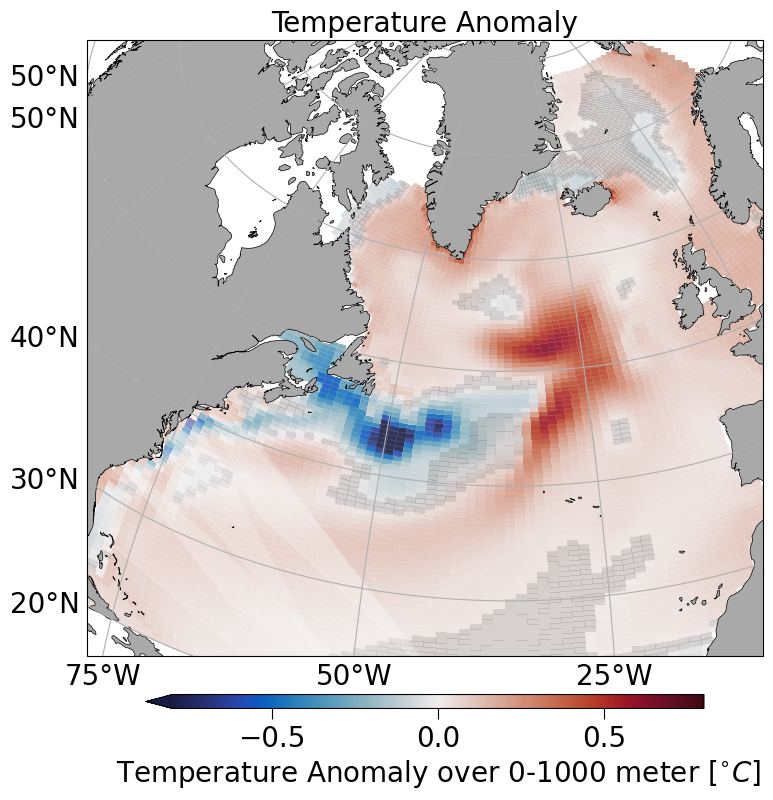

TEMP


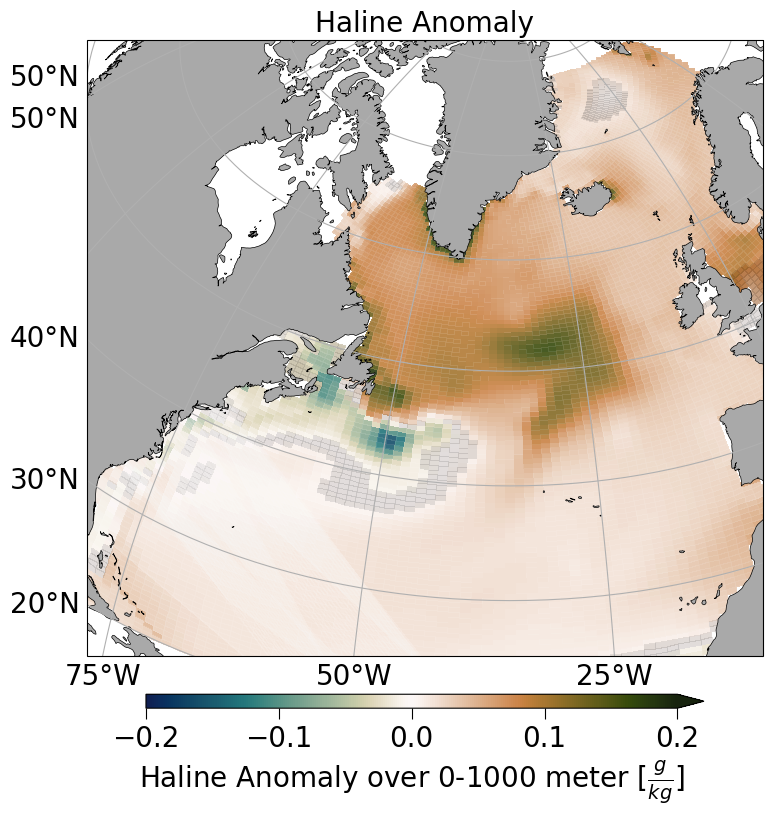

SALT


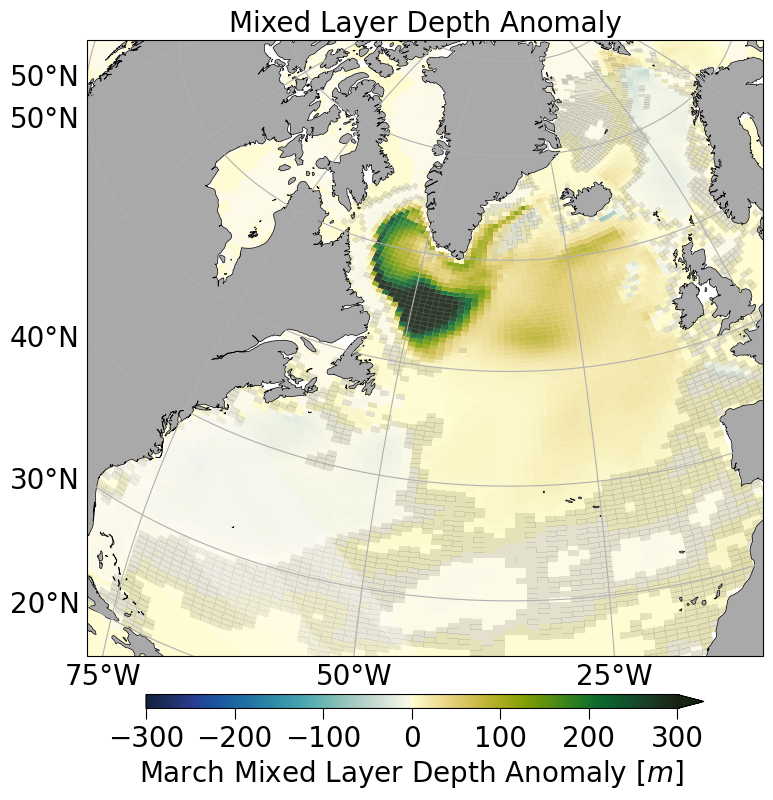

HMXL


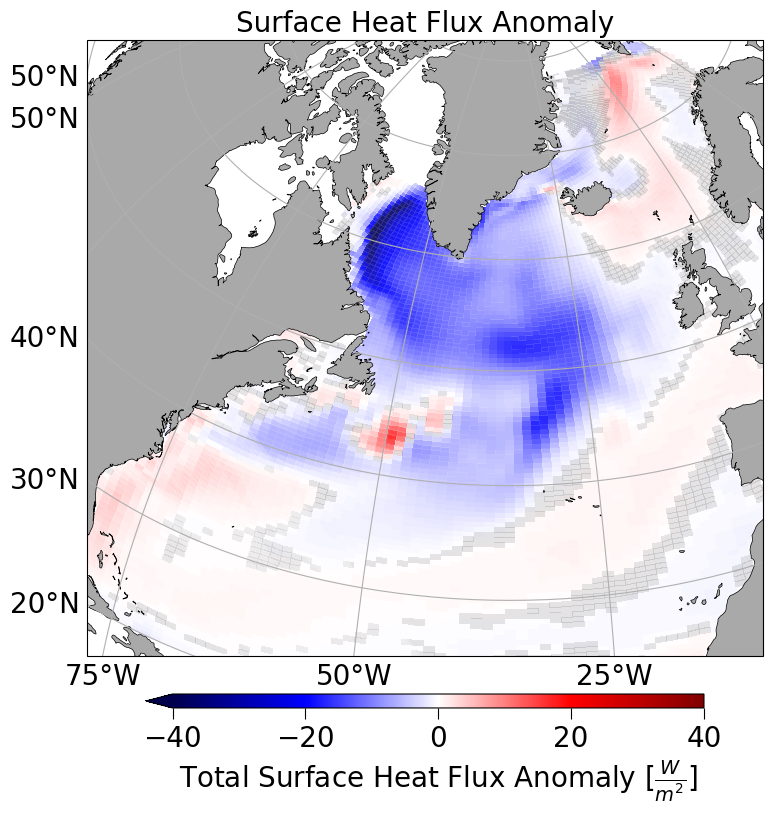

SHF


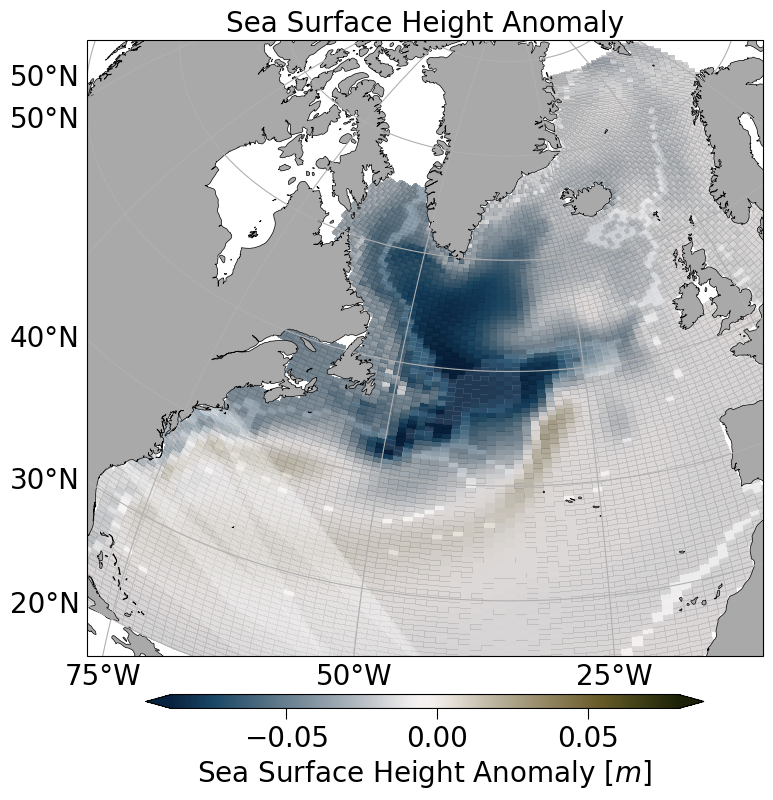

SSH


In [30]:
for i in range(len(data_file)):

    da_data, da_std = open_and_replace(data_file[i], std_file[i], variable_name[i])

    mask = abs(da_data) < da_std

    plot_data(da_data,
              mask,
              titel[i],
              cbar_label[i],
              cmap[i],
              vmin[i],
              variable_name[i])

## Density

In [44]:
sigma_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/sigma_anomaly.nc'
ds_sigma = xr.open_dataset(sigma_file).roll(nlon=+100)

replacement_value = 0
# Replace non-finite values and masked values
ds_sigma['TLAT'] = xr.where(
    np.logical_or(np.isnan(ds_sigma['TLAT']), np.isinf(ds_sigma['TLAT']) | np.ma.getmask(ds_sigma['TLAT'])),
    replacement_value,
    ds_sigma['TLAT']
)

ds_sigma['TLONG'] = xr.where(
    np.logical_or(np.isnan(ds_sigma['TLONG']), np.isinf(ds_sigma['TLONG']) | np.ma.getmask(ds_sigma['TLONG'])),
    replacement_value,
    ds_sigma['TLONG']
)

plotting_data = ds_sigma.SIGMA_2.sel(z_t=slice(5.0000000e+02, 9.8470586e+04)).mean('z_t').squeeze()

In [45]:
vmin = -0.1 #abs(ds_sigma.SIGMA_2).max()
vmax = -vmin 

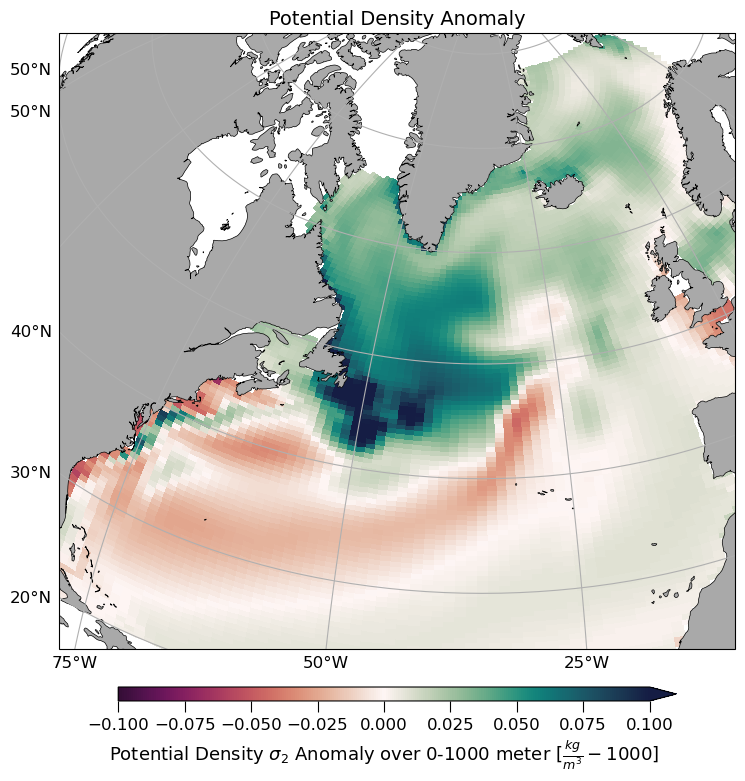

In [46]:
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.8, 'aspect':40, 
               'label':r'Potential Density $\sigma_2$ Anomaly over 0-1000 meter [$\frac{kg}{m^3} -1000$]', 'pad': 0.05}

plt.figure(figsize=(9,10));
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())

pc = plotting_data.plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='TLONG', 
                                    y='TLAT',
                                    cbar_kwargs=cbar_kwargs,
                                    cmap=cmo.curl_r,
                                    vmin = vmin, vmax = vmax, 
                                    )
pc.colorbar.ax.xaxis.label.set_size(13)
pc.colorbar.ax.tick_params(axis='x', labelsize=12, size=8)
ax.tick_params(axis='both', which='both', labelsize=12, size=6)


gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

ax.add_feature(nature_coast);
plt.title('Potential Density Anomaly', fontsize=14)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'sigma_anomaly.png', bbox_inches='tight', dpi=300)

## Sea Level Pressure

In [63]:
psl_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/psl_anomaly.nc'
ds_psl = xr.open_dataset(psl_file)

plotting_data = ds_psl.PSL

In [64]:
vmin = -80
vmax = -vmin

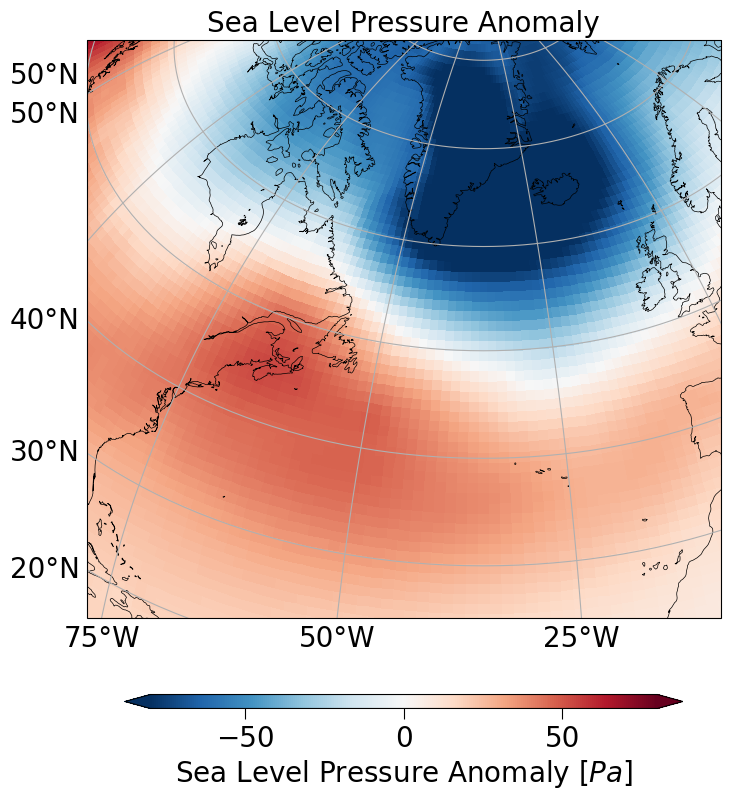

In [86]:
cbar_kwargs = {'orientation':'horizontal', 'shrink':0.6, 'aspect':40, 
               'label':r'Sea Level Pressure Anomaly [$Pa$]', 'pad': 0.1}

plt.figure(figsize=(12,10));
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=40, central_longitude=-35))
ax.set_extent([-80,-10, 25, 80], crs=ccrs.PlateCarree())

pc = plotting_data.plot.pcolormesh(ax=ax, 
                                    transform=ccrs.PlateCarree(),
                                    x='lon', 
                                    y='lat',
                                    cbar_kwargs=cbar_kwargs,
                                    cmap='RdBu_r',
                                    vmin = vmin, vmax = vmax, 
                                    )
pc.colorbar.ax.xaxis.label.set_size(labelsize)
pc.colorbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)
ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)


gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}

psl_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='none')
ax.add_feature(psl_coast);
plt.title('Sea Level Pressure Anomaly', fontsize=labelsize)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'psl_anomaly.png', bbox_inches='tight', dpi=300)